# GAN Generative Adversarial Network

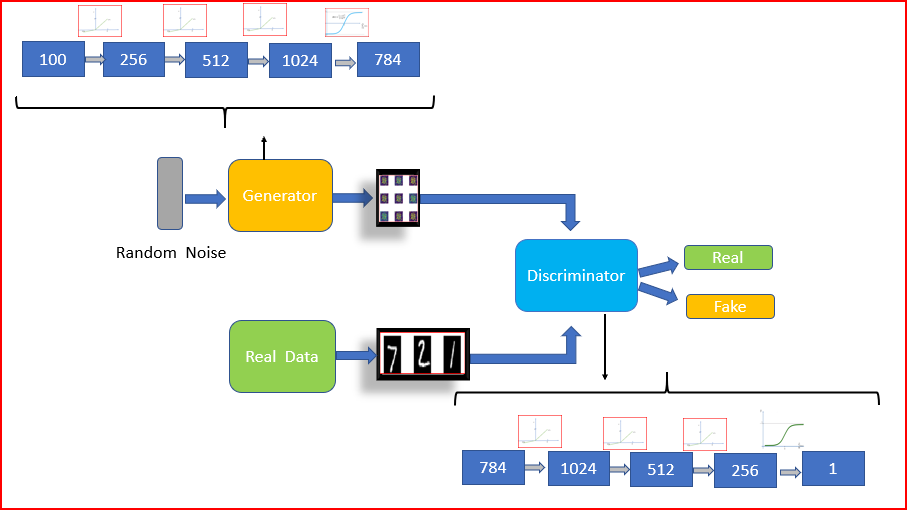

In [1]:
from IPython.display import Image
Image(filename='GAN.png') 

# Import Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

# Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # Load Mnist Data
x_train = (x_train.astype(np.float32) - 127.5)/127.5     # range -1 to +1
x_train = x_train.reshape((60000, 784))                  # Flatten Data

# Create Model

## Create Generator Model

In [4]:
generator = Sequential()
generator.add(Dense(units=256, input_dim=100))
generator.add(LeakyReLU(0.2))

generator.add(Dense(units=512))
generator.add(LeakyReLU(0.2))

generator.add(Dense(units=1024))
generator.add(LeakyReLU(0.2))

generator.add(Dense(units=784, activation='tanh'))

generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

## Discriminator Model

In [6]:
discriminator=Sequential()
discriminator.add(Dense(units=1024,input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))


discriminator.add(Dense(units=512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(units=256))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Dense(units=1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

## Create GAN Model

In [8]:
discriminator.trainable = False
gan_input = Input(shape=(100, ))
x = generator(gan_input) # Defined Network Input
gan_output = discriminator(x) # Defined Network Output
gan = Model(inputs=gan_input, outputs=gan_output) # Create Model
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [9]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


# Training

In [10]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    

100%|███████████████████████████████████████████████████████████████████████████████▊| 399/400 [12:47<00:01,  1.66s/it]C:\Users\wasin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [12:49<00:00,  1.92s/it]


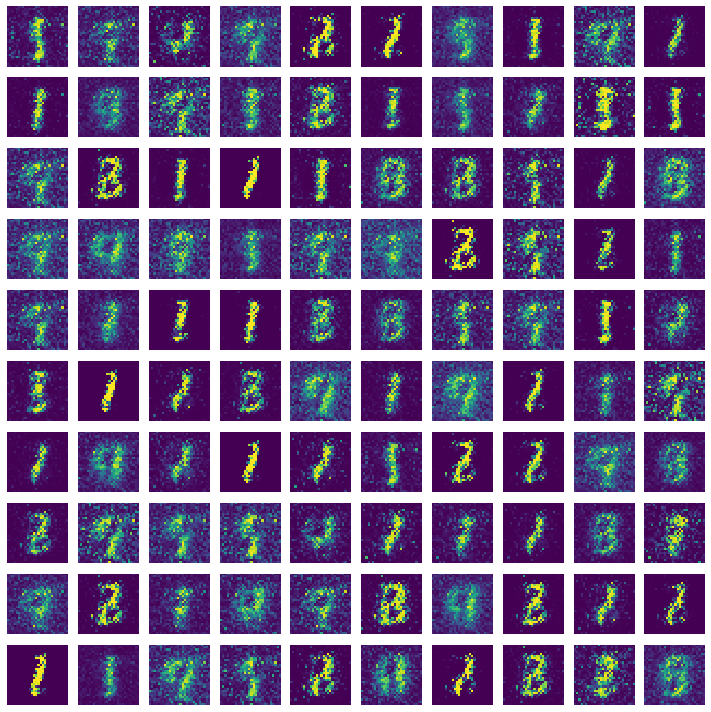

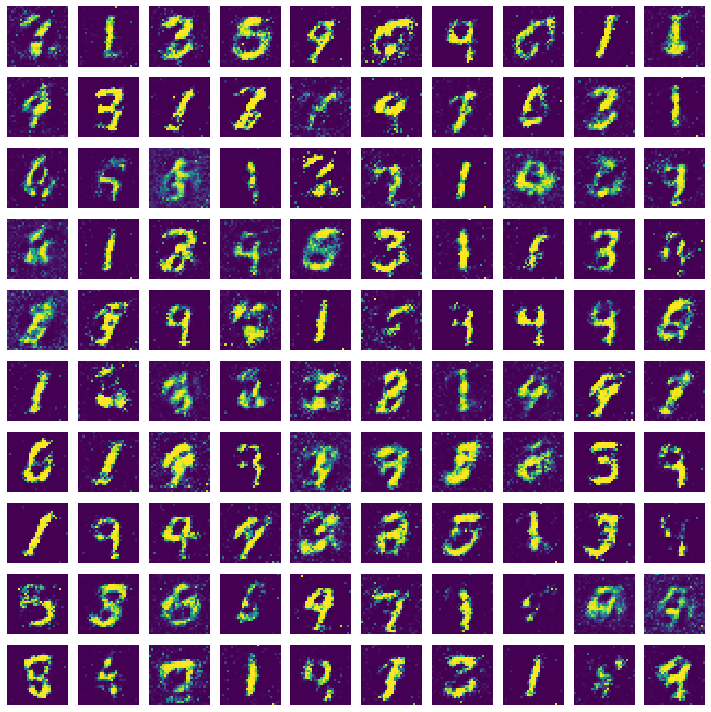

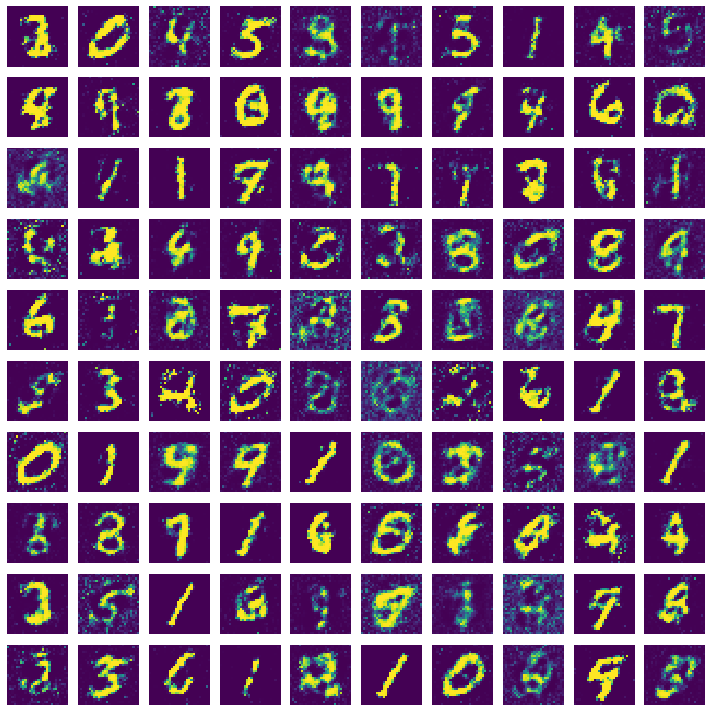

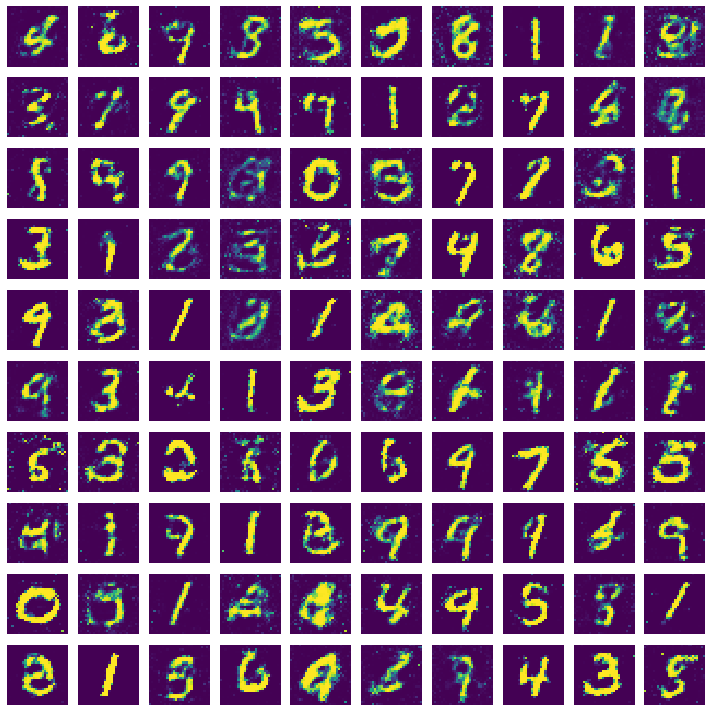

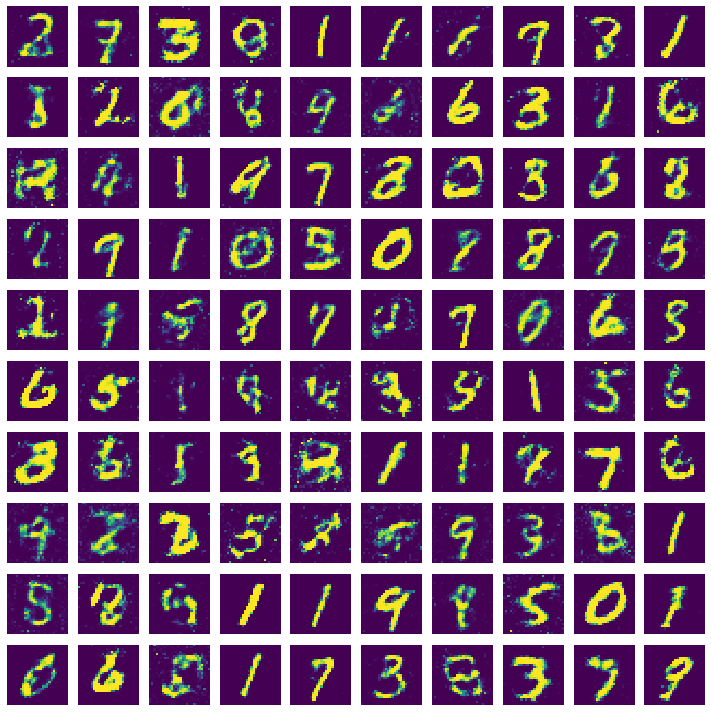

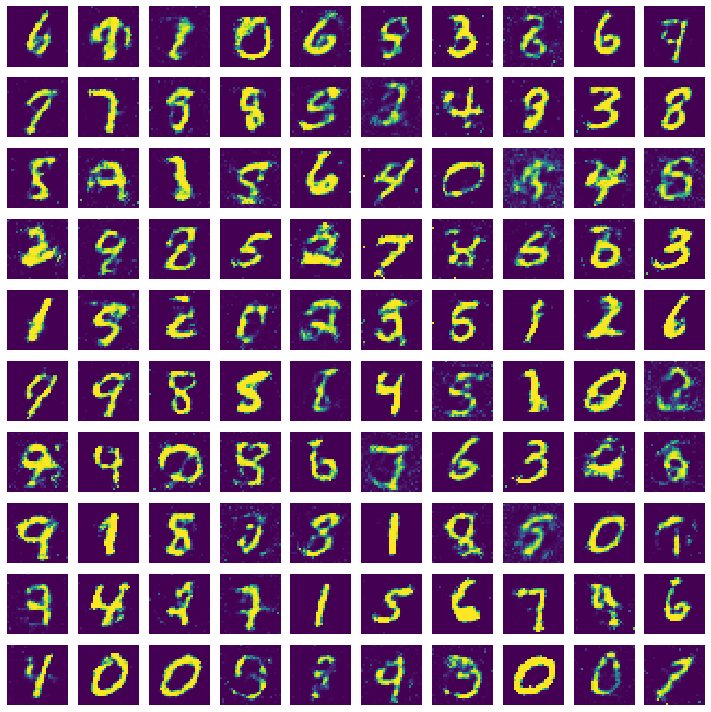

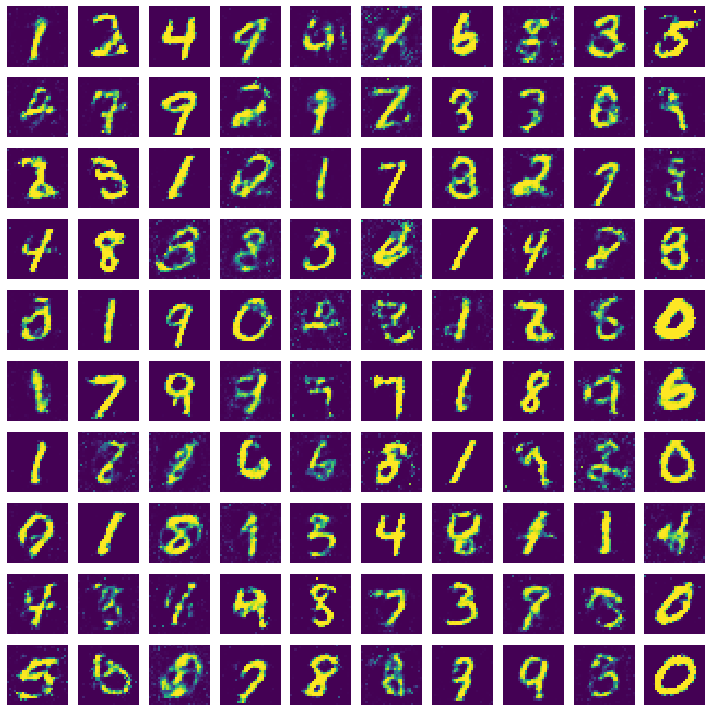

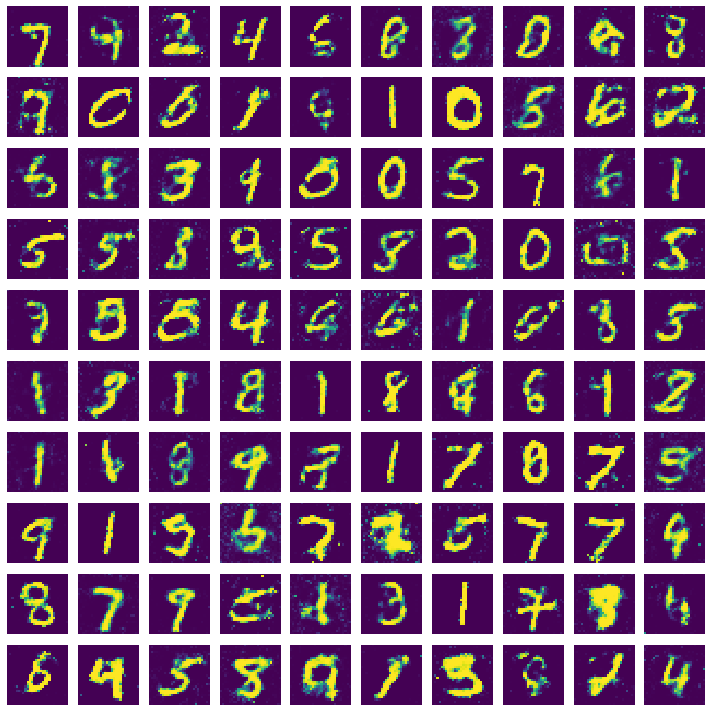

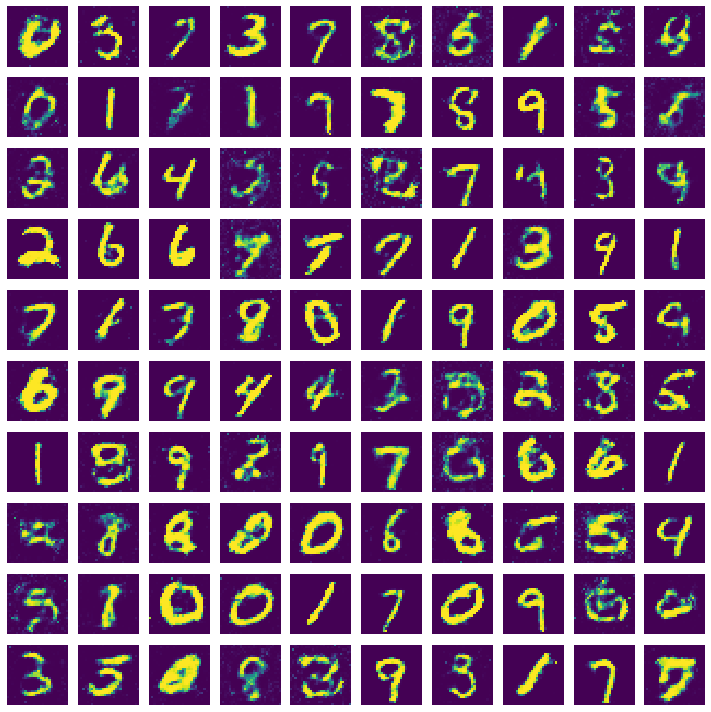

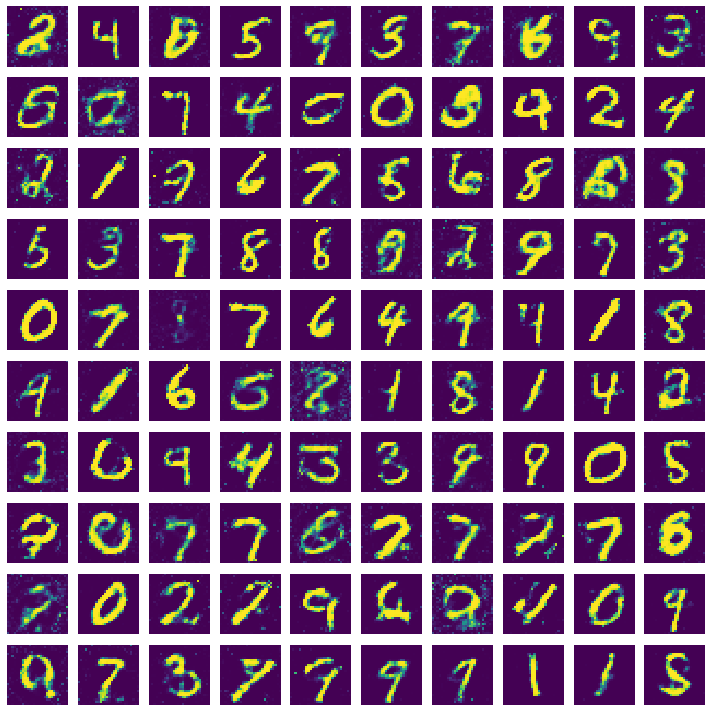

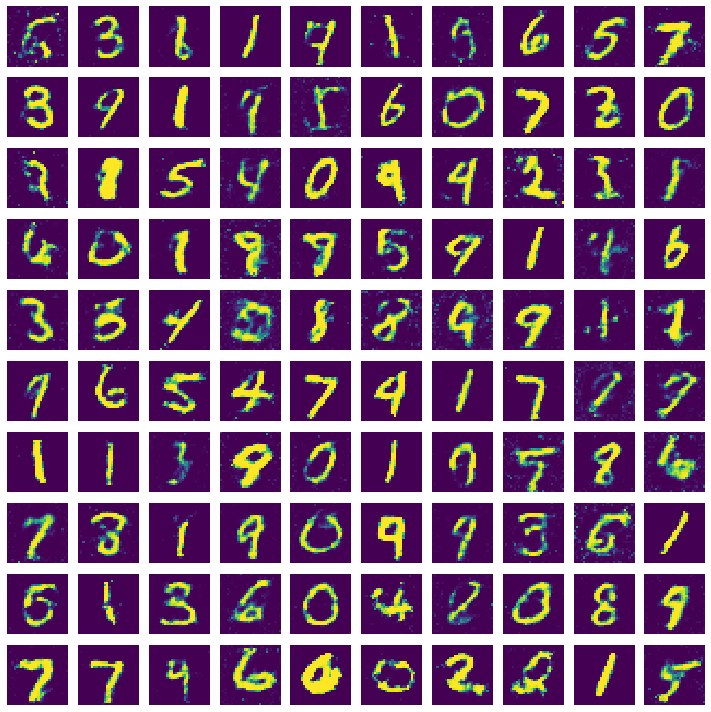

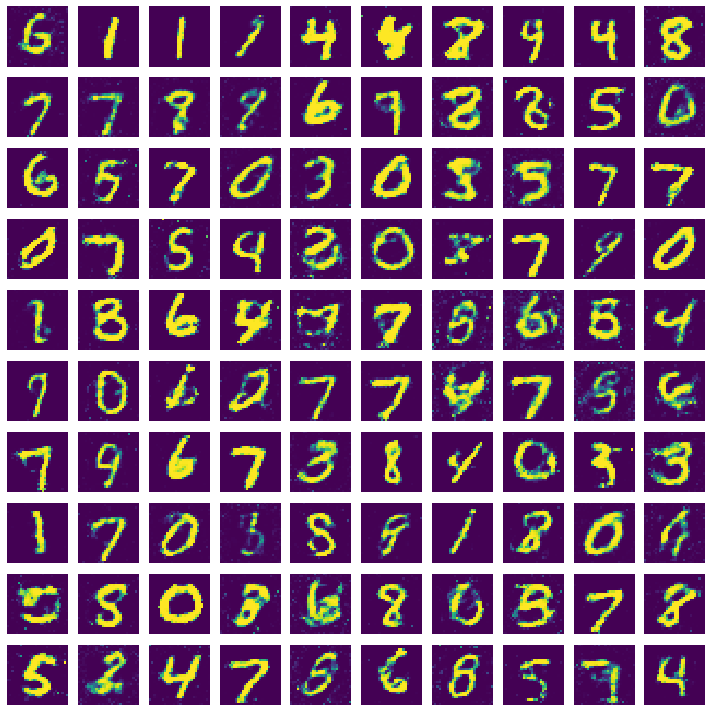

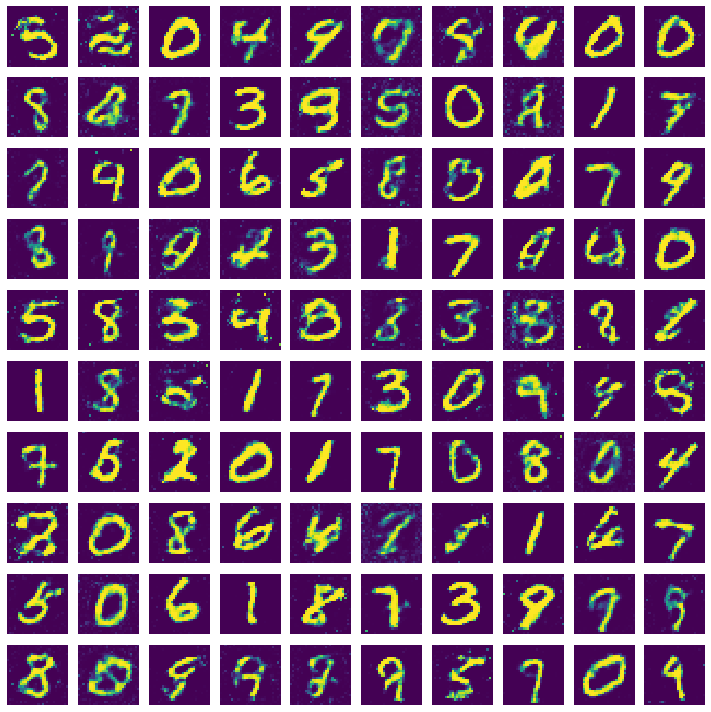

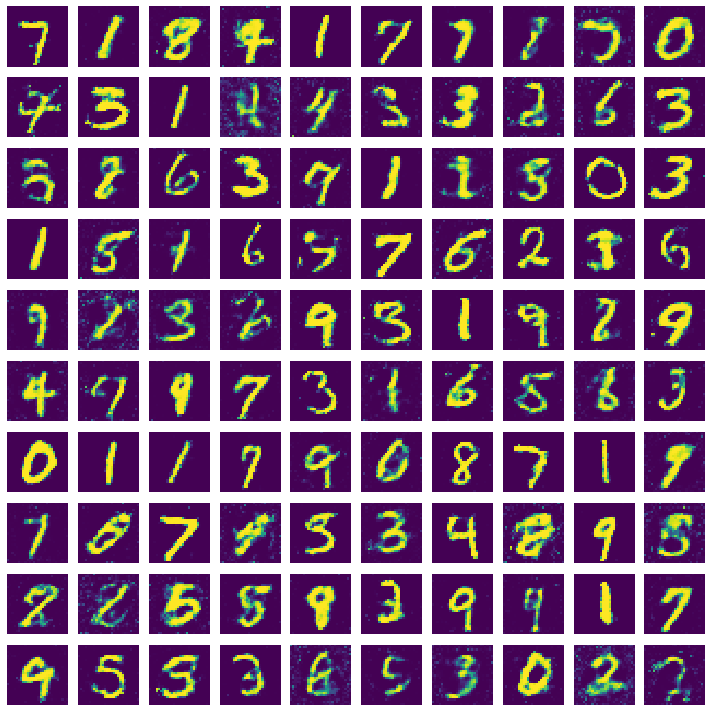

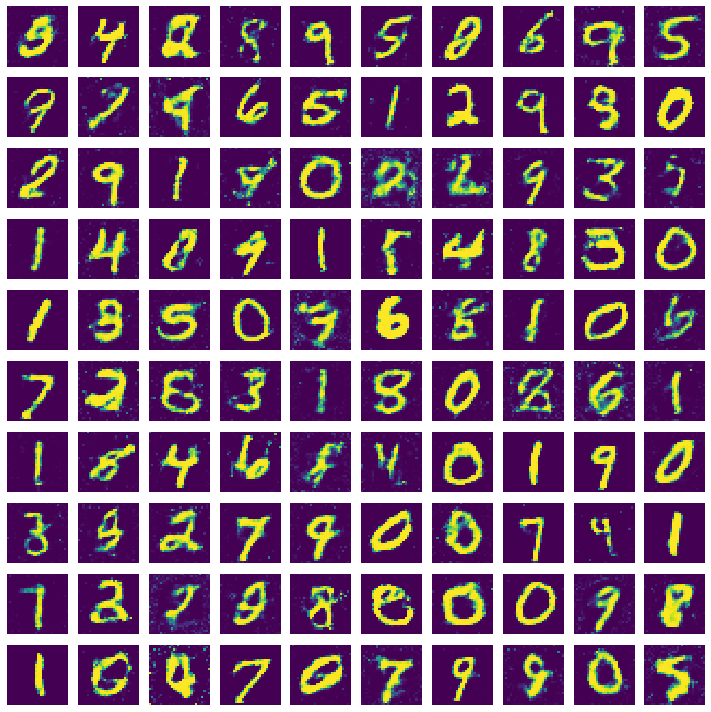

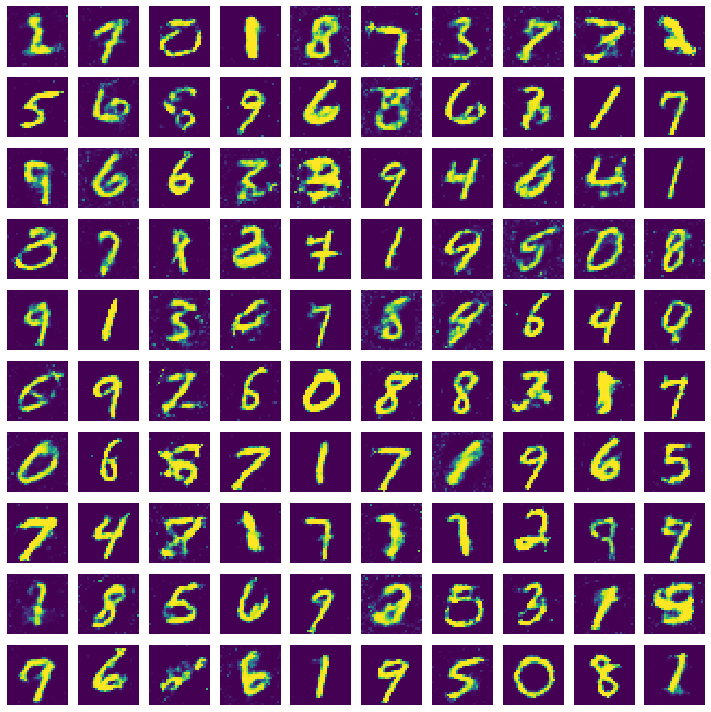

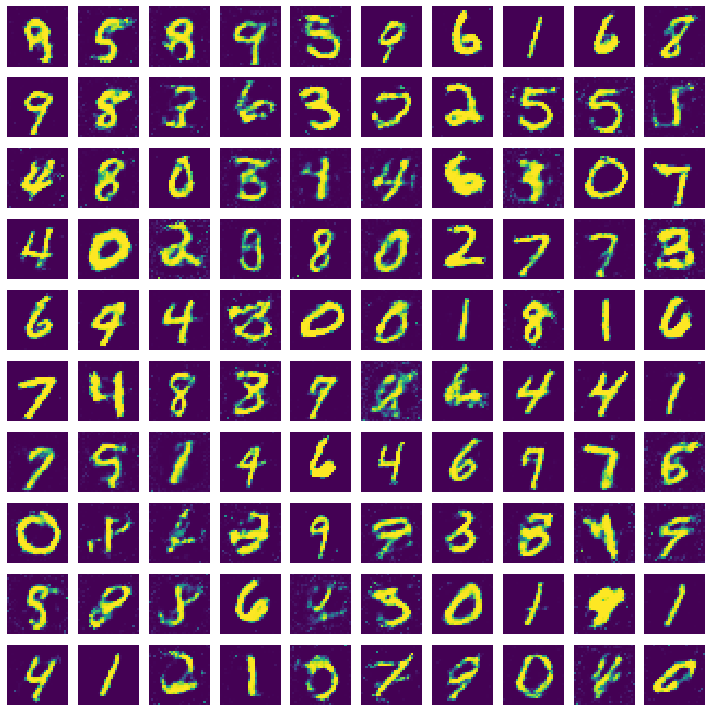

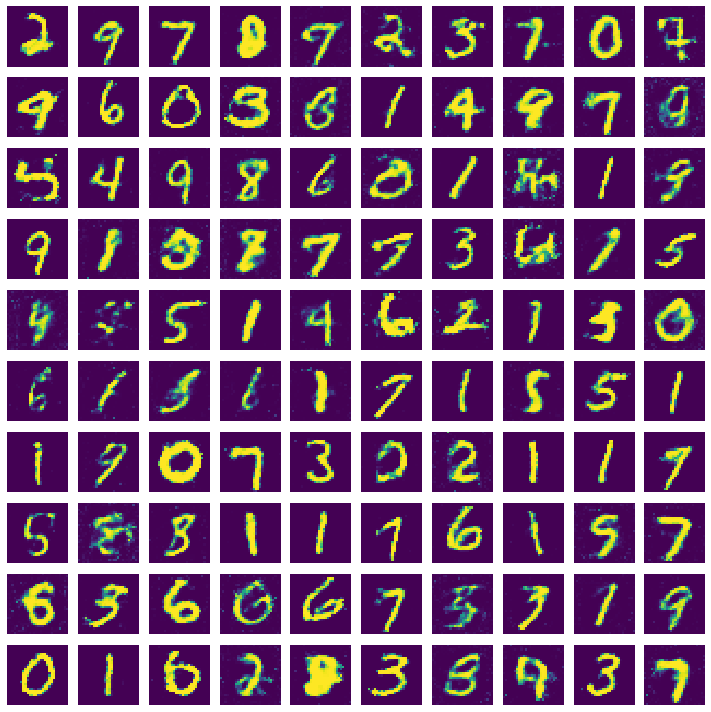

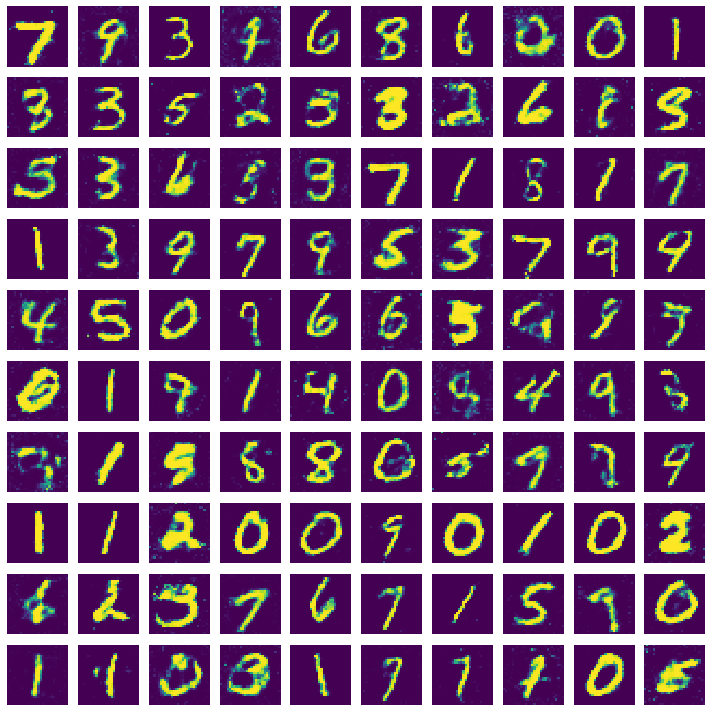

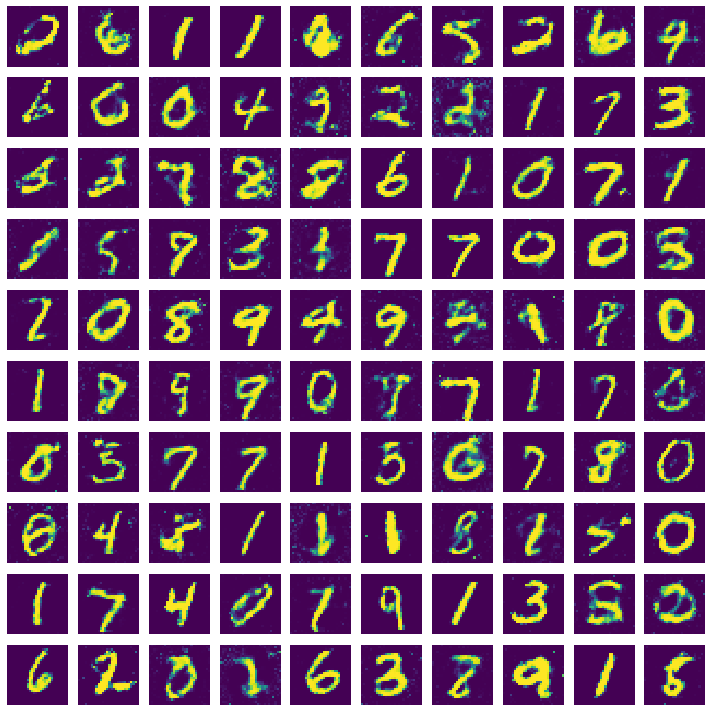

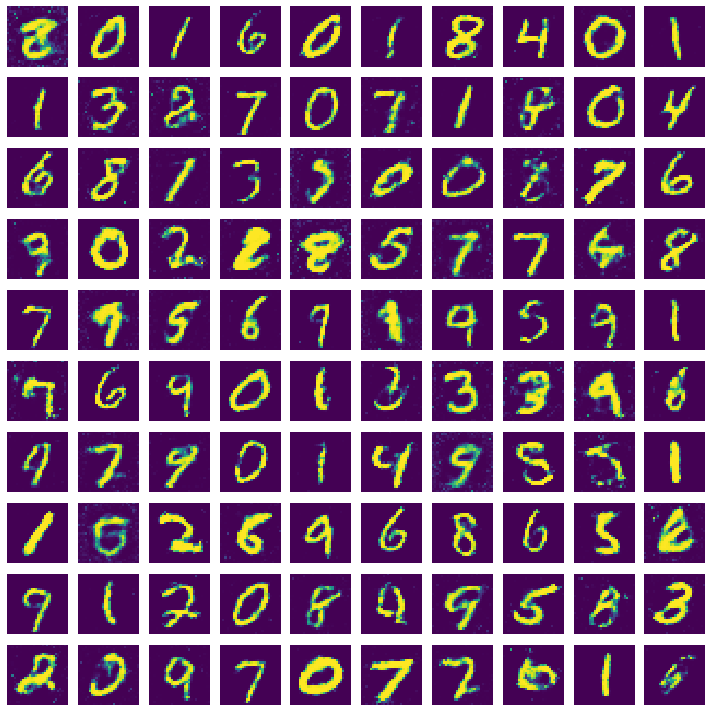

In [13]:
EPOCHS = 400
batch_size = 128

batch_count = x_train.shape[0] / batch_size

for e in tqdm(range(1,EPOCHS + 1)):
    
    for _ in range(batch_size):
        
        # Generate Random Noise
        noise= np.random.normal(0,1, [batch_size, 100])
        
        # Generate Image from Random Noised
        generated_images = generator.predict(noise)

        # pick random Image from Dataset
        image_batch = x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]

        # Create Network Input Data with both real and fake image
        X = np.concatenate([image_batch, generated_images])

        # Labels for generated and real data
        y_dis=np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9

        #Pre train discriminator on  fake and real data  before starting the gan. 
        discriminator.trainable=True
        discriminator.train_on_batch(X, y_dis)

        # Input Noise as real image
        noise= np.random.normal(0, 1, [batch_size, 100])
        y_gen = np.ones(batch_size)

        # Fixed all the weight of the discriminator
        discriminator.trainable = False

        # Train GAN
        gan.train_on_batch(noise, y_gen)

    if e==1 or e%20==0:

        plot_generated_images(e, generator)
            
